<a href="https://colab.research.google.com/github/saritmaitra/Markov_Model/blob/master/Markov_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hmmlearn
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
!pip install ffn
import ffn
from matplotlib import cm
import numpy as np
%matplotlib inline
from sklearn.preprocessing import scale # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, r2_score
import sklearn.mixture as mix
import math, pickle
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings
import seaborn as sns
sns.set()
from hmmlearn.hmm import GaussianHMM
from random import randint
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
warnings.filterwarnings("ignore")

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt

In [12]:
ticker = "^IXIC"
start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2021,3,15)

class DataBase():
  def __init__(self, ticker):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
   
  def quote(self):
    return self.df

db = DataBase(ticker)
df = db.quote()
print(f'Nasdaq Composite Index:')
print(df.tail()); print()
data = df[['High','Low','Open','Adj Close', 'Volume']]
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)
print(data.tail())

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nasdaq Composite Index:
                    Open          High           Low         Close     Adj Close      Volume
Date                                                                                        
2021-03-08  12904.259766  13001.000000  12599.230469  12609.160156  12609.160156  5971260000
2021-03-09  12923.070312  13151.540039  12882.490234  13073.820312  13073.820312  6294910000
2021-03-10  13234.730469  13277.110352  13035.440430  13068.830078  13068.830078  5991730000
2021-03-11  13273.309570  13433.620117  13246.330078  13398.669922  13398.669922  5956260000
2021-03-12  13222.809570  13324.690430  13158.719727  13319.860352  13319.860352  5472340000

                    High           Low          Open     Adj Close      Volume   returns
Date                                                                                    
2021-03-08  13001.000000  12599.230469  12904.259766  12609.160156  5971260000 -0.024365
2021-03-09  13151.540039  12882.490234  12923.070312  130

In [ ]:
# import pandas_datareader as web
# df = web.DataReader('^IXIC', data_source = 'yahoo', start = '2000-01-01')

# print(f'Nasdaq Composite Index:')
# print(df.head())
# print('\n')
# print(df.shape)

In [ ]:
# data = df[['High','Low','Open','Adj Close', 'Volume']]
# data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
# data.dropna(inplace=True)
# data.tail()

count     5331.000000
mean      3878.055904
std       2526.112564
min       1114.109985
25%       2110.954956
50%       2744.610107
75%       4954.110107
max      14095.469727
Name: Adj Close, dtype: float64

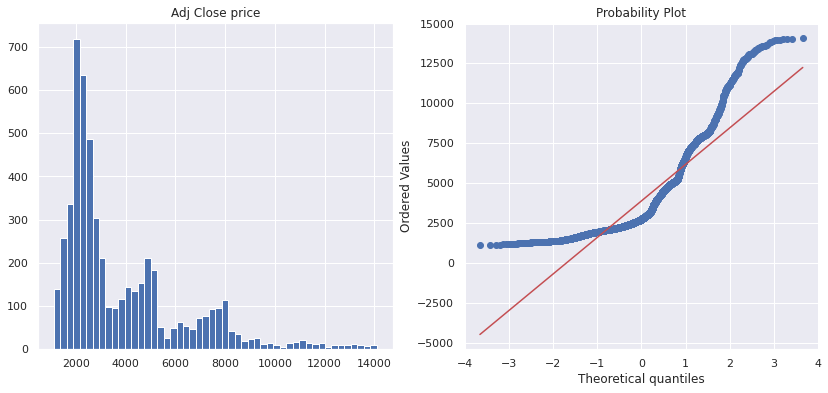

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Adj Close'].hist(bins=50)
plt.title('Adj Close price')
plt.subplot(1,2,2)
stats.probplot(data['Adj Close'], plot=plt);
data['Adj Close'].describe().T

In [14]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['returns'].dropna())

(-16.817441561853464,
 1.1856492504255268e-29,
 17,
 5313,
 {'1%': -3.431581406405848,
  '10%': -2.5670596534355696,
  '5%': -2.8620841555301495},
 -28901.7978190454)

In [15]:
data['state'] = data['returns'].apply(lambda x: 'up' if (x > 0.001)\
else ('down' if (x < -0.001)\
else 'no_change'))
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state
Date,,,,,,,
2021-03-08,13001.000000,12599.230469,12904.259766,12609.160156,5971260000,-0.024365,down
2021-03-09,13151.540039,12882.490234,12923.070312,13073.820312,6294910000,0.036188,up
2021-03-10,13277.110352,13035.440430,13234.730469,13068.830078,5991730000,-0.000382,no_change
2021-03-11,13433.620117,13246.330078,13273.309570,13398.669922,5956260000,0.024925,up
2021-03-12,13324.690430,13158.719727,13222.809570,13319.860352,5472340000,-0.005899,down


In [16]:
data['prev_state'] = data['state'].shift(1)
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state,prev_state
Date,,,,,,,,
2021-03-08,13001.000000,12599.230469,12904.259766,12609.160156,5971260000,-0.024365,down,up
2021-03-09,13151.540039,12882.490234,12923.070312,13073.820312,6294910000,0.036188,up,down
2021-03-10,13277.110352,13035.440430,13234.730469,13068.830078,5991730000,-0.000382,no_change,up
2021-03-11,13433.620117,13246.330078,13273.309570,13398.669922,5956260000,0.024925,up,no_change
2021-03-12,13324.690430,13158.719727,13222.809570,13319.860352,5472340000,-0.005899,down,up


In [46]:
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
print(state_space_matrix); print()
print(state_space_matrix.sum())

state       down  no_change    up
prev_state                       
down         923        153  1131
no_change    184         43   239
up          1099        270  1286

state
down         2206
no_change     466
up           2656
dtype: int64


In [47]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()), axis=1)
print(transition_matrix) ; print()
print(transition_matrix.sum(axis=1))

state           down  no_change        up
prev_state                               
down        0.418215   0.069325  0.512460
no_change   0.394850   0.092275  0.512876
up          0.413936   0.101695  0.484369

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [21]:
t0 = transition_matrix.copy()
t1 = round(t0.dot(t0), 4)
t1

state,down,no_change,up
prev_state,,,
down,0.4146,0.0875,0.4979
no_change,0.4141,0.0880,0.4979
up,0.4140,0.0873,0.4987


In [22]:
t2 = round(t0.dot(t1), 4)
t2

state,down,no_change,up
prev_state,,,
down,0.4143,0.0874,0.4983
no_change,0.4142,0.0874,0.4983
up,0.4143,0.0875,0.4983


In [23]:
t3 = round(t0.dot(t2), 4)
t3

state,down,no_change,up
prev_state,,,
down,0.4143,0.0875,0.4983
no_change,0.4143,0.0875,0.4983
up,0.4143,0.0874,0.4983


In [24]:
pd.DataFrame(np.linalg.matrix_power(t0,4))

<IPython.core.display.Javascript object>

,0,1,2
0,0.414259,0.08743,0.498311
1,0.414259,0.08743,0.498311
2,0.414259,0.08743,0.498312


In [25]:
# find the equilibrium matrix
i=1
a= t0.copy()
b = t0.dot(t0)
while(not(a.equals(b))):
  print('iteration number:' +str(i))
  i += 1
  a = b.copy()
  b = b.dot(t0)

iteration number:1
iteration number:2
iteration number:3
iteration number:4
iteration number:5
iteration number:6
iteration number:7
iteration number:8
iteration number:9
iteration number:10
iteration number:11
iteration number:12


In [26]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(transition_matrix)
pprint(edges_wts)

{('down', 'down'): 0.41847826086956524,
 ('down', 'no_change'): 0.06929347826086957,
 ('down', 'up'): 0.5122282608695652,
 ('no_change', 'down'): 0.3948497854077253,
 ('no_change', 'no_change'): 0.09227467811158799,
 ('no_change', 'up'): 0.5128755364806867,
 ('up', 'down'): 0.4141566265060241,
 ('up', 'no_change'): 0.1016566265060241,
 ('up', 'up'): 0.48418674698795183}


Nodes:
['down', 'no_change', 'up']

Edges:


<IPython.core.display.Javascript object>

           0          1                                                  2
0       down       down  {'weight': 0.41847826086956524, 'label': 0.418...
1       down  no_change  {'weight': 0.06929347826086957, 'label': 0.069...
2       down         up  {'weight': 0.5122282608695652, 'label': 0.5122...
3  no_change       down  {'weight': 0.3948497854077253, 'label': 0.3948...
4  no_change  no_change  {'weight': 0.09227467811158799, 'label': 0.092...
5  no_change         up  {'weight': 0.5128755364806867, 'label': 0.5128...
6         up       down  {'weight': 0.4141566265060241, 'label': 0.4141...
7         up  no_change  {'weight': 0.1016566265060241, 'label': 0.1016...
8         up         up  {'weight': 0.48418674698795183, 'label': 0.484...
None


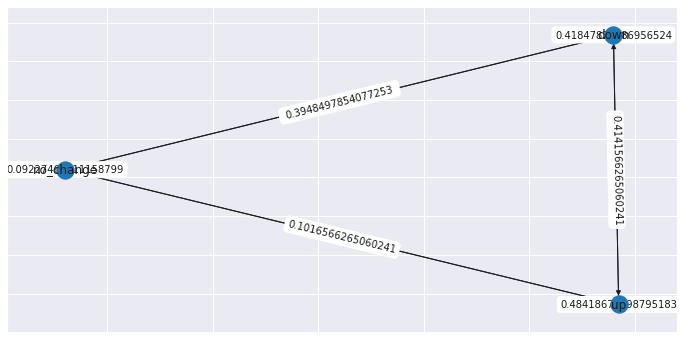

In [27]:
import networkx as nx

states = ['up', 'down', 'no_change']

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(pd.DataFrame(G.edges(data=True)))    

plt.figure(figsize=(12,6))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
print(nx.draw_networkx(G, pos))

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood                7982.049
Date:                Wed, 28 Jul 2021   AIC                         -15940.097
Time:                        13:17:53   BIC                         -15870.209
Sample:                             0   HQIC                        -15914.724
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      7.819      0.000       0.001       0.002
sigma2       2.78e-05   4.14e-06      6.722      0.0

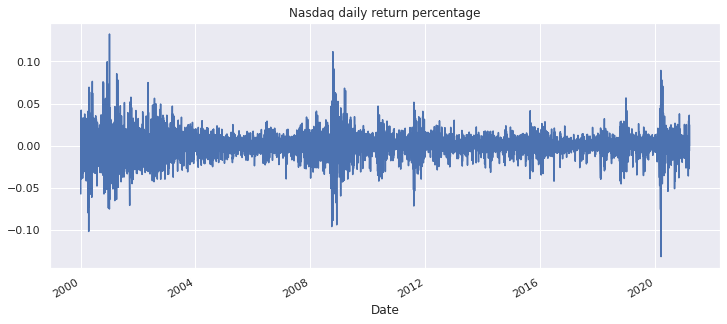

In [28]:
import statsmodels.api as sm

# Plot the data
data['returns'].plot(title='Nasdaq daily return percentage', figsize=(12,5))

data.dropna(inplace=True)

model = sm.tsa.MarkovRegression(data['returns'][-2500:], k_regimes=3,
                                switching_variance=True)


# launch the modelling process on the dataset
np.random.seed(123)
res_1 = model.fit(search_reps=50)

"""We specify that 50 random perturbations from the starting parameter 
vector are examined and the best one used as the actual starting parameters. 

Because of the random nature of the search, the random seed generator 
beforehand allow replication of the result"""

print(res_1.summary())

In [29]:
pred_1 = res_1.predict()
pred_1 = pd.DataFrame(pred_1).tail(20)
pred_1.rename(columns ={0: 'Predicted'}, inplace=True)
com_1 = pd.concat([pred_1, data['returns'].tail(20)], axis=1)
com_1 = com_1.reset_index()
com_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2021-02-12,0.001272,0.004957
1,2021-02-16,0.001042,-0.003409
2,2021-02-17,0.000713,-0.005855
3,2021-02-18,0.000377,-0.007196
4,2021-02-19,0.000005,0.000656
5,2021-02-22,-0.000817,-0.024915
6,2021-02-23,-0.000989,-0.005026
7,2021-02-24,-0.001358,0.009812
8,2021-02-25,-0.001995,-0.035826
9,2021-02-26,-0.002003,0.005543


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['returns'],
                         name="Actual returns"))

fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted returns",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

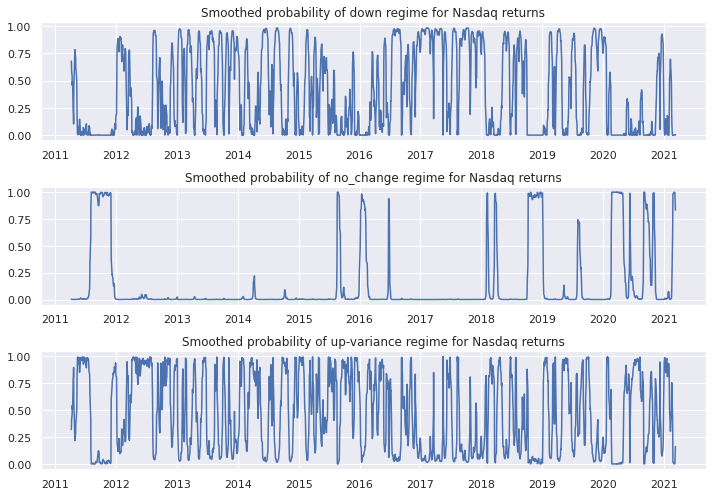

In [31]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_1.smoothed_marginal_probabilities[0])
#ax.fill_between(data['returns'].index, 0,  where=data['returns'].values, color='gray', alpha=0.3)
ax.set(title='Smoothed probability of down regime for Nasdaq returns')
ax = axes[1]
ax.plot(res_1.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime for Nasdaq returns')
ax = axes[2]
ax.plot(res_1.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up-variance regime for Nasdaq returns')
fig.tight_layout()

In [32]:
print(res_1.expected_durations)

[12.02063005 21.83399888 11.32979745]


In [33]:
data['volumeGap'] = np.log(data['Volume'] / data['Volume'].shift()) 
data['dailyChange'] = (data['Adj Close'] - data['Open']) / data['Open']
data['fractHigh'] = (data['High'] - data['Open']) / data['Open']
data['fractLow'] = (data['Open'] - data['Low']) / data['Open']
data['forecastVariable'] = data['Adj Close'].shift(-1) - data['Adj Close']
data.dropna(inplace=True)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
endog = data['returns'][-2500:]
exog = data [['volumeGap', 'dailyChange', 'fractHigh', 'fractLow']][-2500:]


In [34]:
# Fit the 2-regime model
mod_2 = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=3, exog=exog)
res_2 = mod_2.fit(search_reps=50)
print(res_2.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood                9317.116
Date:                Wed, 28 Jul 2021   AIC                         -18590.233
Time:                        13:18:08   BIC                         -18462.104
Sample:                             0   HQIC                        -18543.716
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.822      0.411      -0.002       0.004
x1             0.0177      0.004      4.847      0.0

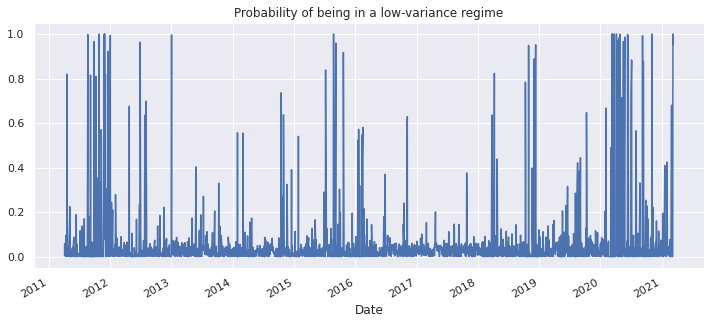

In [35]:
res_2.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in a low-variance regime', figsize=(12,5));

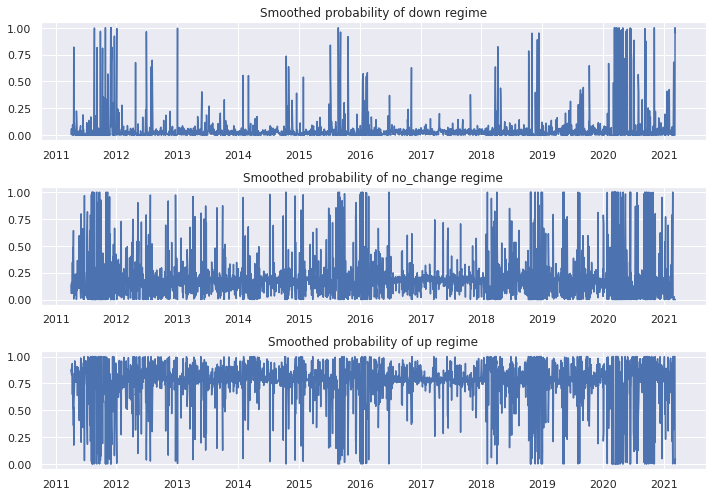

In [36]:
fig, axes = plt.subplots(3, figsize=(10,7))

ax = axes[0]
ax.plot(res_2.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of down regime')

ax = axes[1]
ax.plot(res_2.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime')

ax = axes[2]
ax.plot(res_2.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up regime')

plt.tight_layout()

In [37]:
print(res_2.expected_durations)

[1.22475844 1.16986921 4.16342959]


In [ ]:
!pip install probscale
import probscale

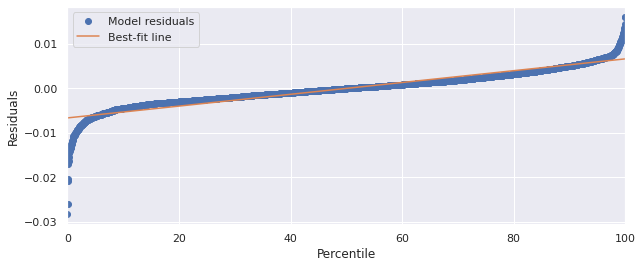

In [39]:
#qqpolot vs. normal distribution
fig, ax = plt.subplots(figsize=(10, 4))
plt.grid(True)
fig = probscale.probplot(res_2.resid, ax=ax, plottype='pp', bestfit=True,
                         problabel='Percentile', datalabel='Residuals',
                         scatter_kws=dict(label='Model residuals'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
plt.show()

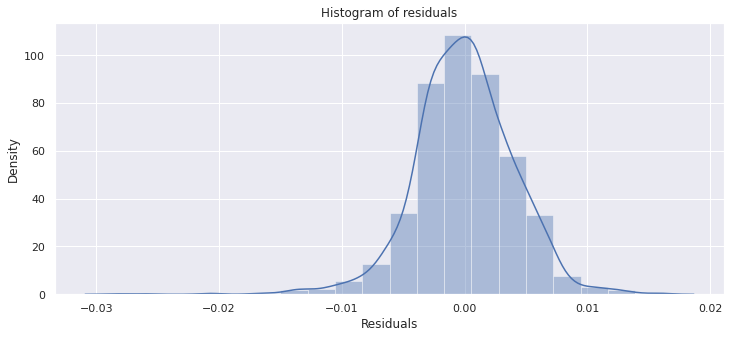

In [40]:
import seaborn as sns
plt.figure(figsize=(12,5))

# Plot a simple histogram with binsize determined automatically
sns.distplot(res_2.resid, 20)
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [41]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
results1 = sms.acorr_breusch_godfrey(res_2, 10)
print(lzip(name, results1))

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(res_2.resid)
print(lzip(name, results1))

[('Lagrange multiplier statistic', 7.669158169403278), ('p-value', 0.6611171029877623), ('f-value', 0.7645244826195098), ('f p-value', 0.6633914126596472)]
[('Jarque-Bera', 7.669158169403278), ('Chi^2 two-tail prob.', 0.6611171029877623), ('Skew', 0.7645244826195098), ('Kurtosis', 0.6633914126596472)]


In [42]:
print(res_2.expected_durations)

[1.22475844 1.16986921 4.16342959]


In [43]:
print(res_2.conf_int())

                 0         1
p[0->0]   0.067241  0.299784
p[1->0]   0.040517  0.157954
p[2->0]   0.015863  0.051502
p[0->1]   0.056811  0.362035
p[1->1]   0.072632  0.217775
p[2->1]   0.147727  0.265282
const[0] -0.001635  0.003996
const[1]  0.002660  0.004952
const[2]  0.000217  0.001090
x1[0]     0.010543  0.024858
x1[1]    -0.008823 -0.001805
x1[2]    -0.001054  0.001499
x2[0]     0.683389  1.149860
x2[1]     1.461182  1.673385
x2[2]     1.191892  1.324384
x3[0]     0.609351  1.330331
x3[1]    -1.467224 -1.267447
x3[2]    -0.261717 -0.107007
x4[0]     0.463702  0.764045
x4[1]    -0.314675 -0.062719
x4[2]     0.189414  0.317648
sigma2    0.000020  0.000024


In [44]:
predict = res_2.predict()
predict = pd.DataFrame(predict.tail(20))
predict.rename(columns ={0: 'Predicted'}, inplace=True)
combine = pd.concat([predict, data['returns'].tail(20)], axis=1)
combine = combine.reset_index()
combine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2021-02-11,0.000914,0.003803
1,2021-02-12,0.008844,0.004957
2,2021-02-16,-0.006112,-0.003409
3,2021-02-17,0.004045,-0.005855
4,2021-02-18,0.001050,-0.007196
5,2021-02-19,-0.002866,0.000656
6,2021-02-22,-0.021528,-0.024915
7,2021-02-23,-0.003899,-0.005026
8,2021-02-24,0.013171,0.009812
9,2021-02-25,-0.028796,-0.035826


In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=combine['Date'],y=combine['returns'],
                         name="Actual Values (Adj Close"))

fig.add_trace(go.Scatter(x=combine['Date'],y=combine['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted values",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=500,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>